In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

get_ipython().magic('matplotlib inline')

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    
])

dataset = datasets.ImageFolder('pokemon',transform=transform)

batch_size = 128
num_workers = 4

dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)

In [4]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

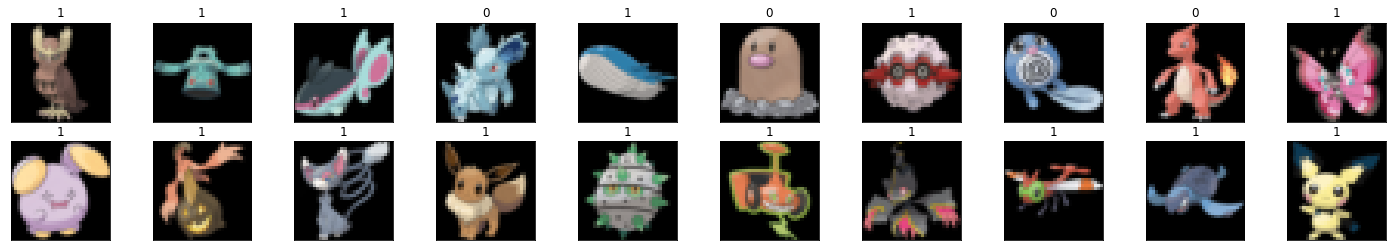

In [5]:
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

In [6]:
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())
print(img.shape)

Min:  tensor(0.)
Max:  tensor(0.8863)
torch.Size([3, 32, 32])


In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    minq,maxq = feature_range
    x = x * (maxq-minq) + minq
    return x

In [8]:
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.7725)


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim

        self.layer_1 = conv(3,conv_dim,4,batch_norm=False)
        self.layer_2 = conv(conv_dim,conv_dim*2,4,batch_norm=True)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4,batch_norm=True)
        self.fc = nn.Linear(4*4*conv_dim*4,1)

    def forward(self, x):
        x = F.leaky_relu(self.layer_1(x),0.2)
        x = F.leaky_relu(self.layer_2(x),0.2)
        x = F.leaky_relu(self.layer_3(x),0.2)
        x = x.view(-1,4*4*self.conv_dim*4)
        x = self.fc(x)
        return x

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias = False))
    
    if(batch_norm):
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size,conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4,conv_dim*2,4)
        self.t_conv2 = deconv(conv_dim*2,conv_dim,4)
        self.t_conv3 = deconv(conv_dim,3,4,batch_norm=False)
        

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1,4*self.conv_dim,4,4)
        x = F.leaky_relu(self.t_conv1(x))
        x = F.leaky_relu(self.t_conv2(x))
        x = self.t_conv3(x)
        x = F.tanh(x)
        return x

In [13]:
conv_dim = 32
z_size = 100

D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (layer_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [14]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


In [15]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [16]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [25]:
import pickle as pkl

# training hyperparams
num_epochs = 500

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(dataloader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

C:\Users\anil\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  500] | d_loss: 0.5791 | g_loss: 1.4272
Epoch [    2/  500] | d_loss: 0.5880 | g_loss: 1.9200
Epoch [    3/  500] | d_loss: 1.4052 | g_loss: 3.1090
Epoch [    4/  500] | d_loss: 0.5191 | g_loss: 1.3980
Epoch [    5/  500] | d_loss: 0.7416 | g_loss: 2.4242
Epoch [    6/  500] | d_loss: 0.8022 | g_loss: 2.8835
Epoch [    7/  500] | d_loss: 0.5625 | g_loss: 2.1231
Epoch [    8/  500] | d_loss: 0.5248 | g_loss: 1.4456
Epoch [    9/  500] | d_loss: 0.5554 | g_loss: 1.4133
Epoch [   10/  500] | d_loss: 0.7069 | g_loss: 2.4449
Epoch [   11/  500] | d_loss: 0.6461 | g_loss: 1.0655
Epoch [   12/  500] | d_loss: 0.5451 | g_loss: 1.4517
Epoch [   13/  500] | d_loss: 0.6659 | g_loss: 1.1657
Epoch [   14/  500] | d_loss: 0.6124 | g_loss: 2.2205
Epoch [   15/  500] | d_loss: 0.5874 | g_loss: 1.8159
Epoch [   16/  500] | d_loss: 1.2958 | g_loss: 0.6375
Epoch [   17/  500] | d_loss: 0.6645 | g_loss: 1.6724
Epoch [   18/  500] | d_loss: 0.5762 | g_loss: 1.5854
Epoch [   19/  500] | d_loss

Epoch [  152/  500] | d_loss: 0.6255 | g_loss: 1.4504
Epoch [  153/  500] | d_loss: 0.6043 | g_loss: 1.7553
Epoch [  154/  500] | d_loss: 1.6370 | g_loss: 3.6894
Epoch [  155/  500] | d_loss: 0.6681 | g_loss: 1.5513
Epoch [  156/  500] | d_loss: 0.6274 | g_loss: 2.4086
Epoch [  157/  500] | d_loss: 0.5994 | g_loss: 1.9317
Epoch [  158/  500] | d_loss: 0.6716 | g_loss: 1.3591
Epoch [  159/  500] | d_loss: 0.6367 | g_loss: 0.9949
Epoch [  160/  500] | d_loss: 0.9296 | g_loss: 2.5395
Epoch [  161/  500] | d_loss: 0.6311 | g_loss: 1.4988
Epoch [  162/  500] | d_loss: 1.1162 | g_loss: 2.4389
Epoch [  163/  500] | d_loss: 0.6289 | g_loss: 1.7752
Epoch [  164/  500] | d_loss: 0.8205 | g_loss: 0.8662
Epoch [  165/  500] | d_loss: 0.5994 | g_loss: 1.0567
Epoch [  166/  500] | d_loss: 0.5989 | g_loss: 1.8712
Epoch [  167/  500] | d_loss: 0.6200 | g_loss: 1.1498
Epoch [  168/  500] | d_loss: 0.5922 | g_loss: 1.7001
Epoch [  169/  500] | d_loss: 0.8463 | g_loss: 0.3884
Epoch [  170/  500] | d_loss

Epoch [  303/  500] | d_loss: 0.5084 | g_loss: 2.3324
Epoch [  304/  500] | d_loss: 0.4479 | g_loss: 2.2314
Epoch [  305/  500] | d_loss: 0.4178 | g_loss: 2.0442
Epoch [  306/  500] | d_loss: 0.6318 | g_loss: 1.5453
Epoch [  307/  500] | d_loss: 0.4335 | g_loss: 1.7770
Epoch [  308/  500] | d_loss: 0.3874 | g_loss: 1.9890
Epoch [  309/  500] | d_loss: 0.5256 | g_loss: 2.7493
Epoch [  310/  500] | d_loss: 0.4633 | g_loss: 2.5103
Epoch [  311/  500] | d_loss: 0.9466 | g_loss: 3.3356
Epoch [  312/  500] | d_loss: 0.4149 | g_loss: 1.7437
Epoch [  313/  500] | d_loss: 0.3993 | g_loss: 1.8912
Epoch [  314/  500] | d_loss: 0.4109 | g_loss: 1.7638
Epoch [  315/  500] | d_loss: 0.4195 | g_loss: 2.4824
Epoch [  316/  500] | d_loss: 0.5103 | g_loss: 1.7386
Epoch [  317/  500] | d_loss: 0.4021 | g_loss: 2.2130
Epoch [  318/  500] | d_loss: 0.3878 | g_loss: 1.7795
Epoch [  319/  500] | d_loss: 0.3821 | g_loss: 1.8441
Epoch [  320/  500] | d_loss: 0.5505 | g_loss: 0.8570
Epoch [  321/  500] | d_loss

Epoch [  454/  500] | d_loss: 0.3785 | g_loss: 3.9074
Epoch [  455/  500] | d_loss: 0.2354 | g_loss: 2.5465
Epoch [  456/  500] | d_loss: 0.2415 | g_loss: 2.7623
Epoch [  457/  500] | d_loss: 0.2113 | g_loss: 2.3370
Epoch [  458/  500] | d_loss: 0.2418 | g_loss: 2.6950
Epoch [  459/  500] | d_loss: 0.2239 | g_loss: 2.1202
Epoch [  460/  500] | d_loss: 0.2599 | g_loss: 3.3568
Epoch [  461/  500] | d_loss: 0.2490 | g_loss: 2.9857
Epoch [  462/  500] | d_loss: 0.2635 | g_loss: 3.0737
Epoch [  463/  500] | d_loss: 0.2151 | g_loss: 2.5622
Epoch [  464/  500] | d_loss: 0.2227 | g_loss: 2.7951
Epoch [  465/  500] | d_loss: 0.2164 | g_loss: 2.4969
Epoch [  466/  500] | d_loss: 0.2133 | g_loss: 2.6685
Epoch [  467/  500] | d_loss: 0.2120 | g_loss: 2.2247
Epoch [  468/  500] | d_loss: 0.2686 | g_loss: 3.3218
Epoch [  469/  500] | d_loss: 0.2222 | g_loss: 3.2666
Epoch [  470/  500] | d_loss: 0.2340 | g_loss: 2.5849
Epoch [  471/  500] | d_loss: 0.2591 | g_loss: 3.7062
Epoch [  472/  500] | d_loss

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 2.00 GiB total capacity; 1.25 GiB already allocated; 659.20 KiB free; 92.55 MiB cached)

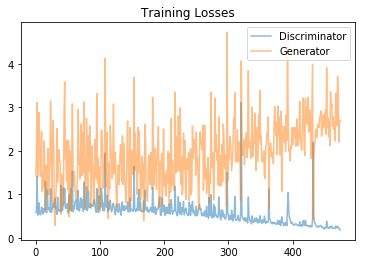

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [29]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

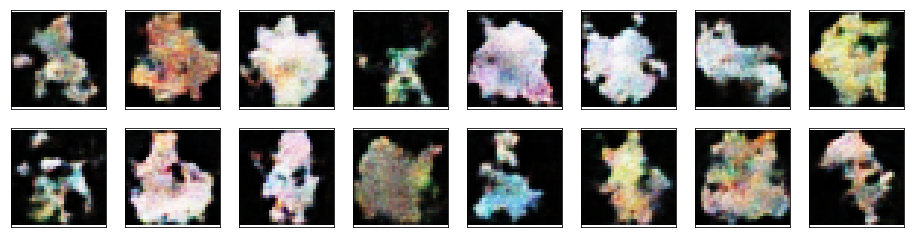

In [34]:
_ = view_samples(-1, samples)